<a href="https://colab.research.google.com/github/NotIshi28/LLM/blob/main/nubllm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('reddit')

reddit


In [44]:
!wget https://raw.githubusercontent.com/NotIshi28/LLM/main/reddit_short_stories.txt
!wget https://raw.githubusercontent.com/NotIshi28/LLM/main/requirements.txt
!wget https://raw.githubusercontent.com/NotIshi28/LLM/main/supplementary.py

--2024-09-06 17:54:08--  https://raw.githubusercontent.com/NotIshi28/LLM/main/reddit_short_stories.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 408536 (399K) [text/plain]
Saving to: ‘reddit_short_stories.txt’

reddit_short_storie 100%[===================>] 398.96K  --.-KB/s    in 0.03s   

2024-09-06 17:54:09 (12.7 MB/s) - ‘reddit_short_stories.txt’ saved [408536/408536]



In [32]:
!pip install -r requirements.txt

In [45]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.7.1
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.4.0+cu121


In [82]:
import torch
from supplementary import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 1024, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [48]:
import tiktoken
from supplementary import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [49]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [50]:

with open("reddit_short_stories.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

In [51]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 408536
Tokens: 101686


In [96]:
from supplementary import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=1024,
    stride=1024,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [97]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 102

In [98]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 90112
Validation tokens: 10240
All tokens: 100352


In [99]:
from supplementary import calc_loss_loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 2.405170278115706
Validation loss: 7.221398544311524


In [100]:
from supplementary import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [90]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="A coincidence is always possible", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.691, Val loss 9.732
Ep 1 (Step 000005): Train loss 8.067, Val loss 8.172
Ep 1 (Step 000010): Train loss 7.370, Val loss 7.311
Ep 1 (Step 000015): Train loss 6.821, Val loss 6.992
Ep 1 (Step 000020): Train loss 6.879, Val loss 6.925
Ep 1 (Step 000025): Train loss 6.562, Val loss 6.861
Ep 1 (Step 000030): Train loss 6.216, Val loss 6.758
Ep 1 (Step 000035): Train loss 6.386, Val loss 6.667
Ep 1 (Step 000040): Train loss 6.351, Val loss 6.605
Ep 1 (Step 000045): Train loss 6.296, Val loss 6.586
Ep 1 (Step 000050): Train loss 6.262, Val loss 6.562
Ep 1 (Step 000055): Train loss 6.126, Val loss 6.551
Ep 1 (Step 000060): Train loss 6.298, Val loss 6.465
Ep 1 (Step 000065): Train loss 5.990, Val loss 6.413
Ep 1 (Step 000070): Train loss 6.047, Val loss 6.365
Ep 1 (Step 000075): Train loss 5.933, Val loss 6.314
Ep 1 (Step 000080): Train loss 5.897, Val loss 6.310
Ep 1 (Step 000085): Train loss 6.134, Val loss 6.282
A coincidence is always possible <nl> "It was 

In [91]:
torch.save(model.state_dict(), "model.pth")

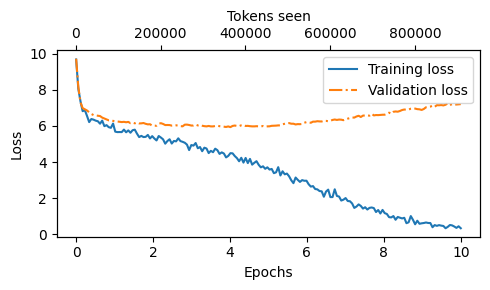

In [92]:
from supplementary import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [93]:
import torch

# Imports from a local file
from supplementary import GPTModel


model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

In [103]:
from supplementary import generate_text_simple
start_context =  input()
tokenizer = tiktoken.get_encoding("gpt2")


device = torch.device("cuda")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(device),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

i saw something in the night sky that
Output text:
 i saw something in the night sky that had been evacuated to begin with sweet nicotine, and
